# Before we start...

This colab notebook is a minimum demo for faceswap-GAN v2.2. Since colab allows maximum run time limit of 12 hrs, we will only train a lightweight model in this notebook. **The purpose of this notebook is not to train a model that produces high quality results but a quick overview for how faceswap-GAN works.**

The pipeline of faceswap-GAN v2.2 is described below:

  1. Upload two videos for training.
  2. Apply face extraction (preprocessing) on the two uploaded videos
  3. Train a liteweight faceswap-GAN model. (This will take 10 ~ 12 hrs)
  4. Apply video conversion to the uploaded videos.

# Step 1: Set runtime type to Python 3/GPU


Set the colab notebook to GPU instance through: runtime -> change runtime type -> Python3 and GPU

The following cells will show the system information of the current instance. Run the cells and check if it uses python >= 3.6 and has a GPU device.

In [0]:
import platform
print(platform.python_version()) 

3.6.9


# Step 2: Change version of CUDA and tensorflow

- CUDA 9.0
- Tensorflow 1.8.0
- Tensorflow-gpu 1.8.0

after change it all ,you need to restart runtime

In [0]:

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!dpkg -i cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!apt-get install cuda=9.0.176-1

--2020-05-16 03:27:59--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?KVwk_--joGU5zMBiJAcw14kgWiTWUWBEZU1qZPTOOX6GUGlZ8mtQBJ5nC2XsZTfxSi_V7v6tSw3HisJ_OHOPNi5ubrOhh72i9rpkDmsX6mXhKciImAnfGcpjUqqGKUebITIG2onBqEuonY4EMKoo34wpbStduCWQXfsYFZr4hvXl7jMGWUUpTgaKmEbD3xLyNRP_g3WAvmSVOnlKeBxe [following]
--2020-05-16 03:28:00--  https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-0-local_9.0.176-1_amd64.deb?KVwk_--joGU5zMBiJAcw14kgWiTWUWBEZU1qZPTOOX6GUGlZ8mtQBJ5nC2XsZTfxSi_V7v6tSw3HisJ_OHOPNi5ubrOhh72i9rpkDmsX6mXhKciImAnf

In [0]:
!pip install tensorflow==1.8.0

     |████████████████████████████████| 49.1MB 63kB/s 
     |████████████████████████████████| 3.1MB 62.1MB/s 
     |████████████████████████████████| 890kB 55.4MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=0ca9f781958f8eadb90c7df0680f3a20ab5c1a4bf9d9d21281c3c7e0167a9022
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.5
    Uninstalling bleach-3.1.5:
      Successfully uninstalled bleach-3.1.5
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [0]:
!pip install tensorflow-gpu==1.8.0

     |████████████████████████████████| 216.3MB 19kB/s 


In [0]:
#　tf version should be 1.8.0
import tensorflow as tf
tf.__version__

'1.8.0'

# Step 3: check your tf version and cuda version 

In [0]:
# chaeck CUDA version
!cat /usr/local/cuda/version.txt

CUDA Version 9.0.176


In [0]:
#  gpu 
!nvidia-smi

Sat May 16 06:37:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |  15673MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# order gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
# devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8610200990216659331, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15900377088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15624807694191192358
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
# GPU available
tf.test.is_gpu_available()

True

In [0]:
# google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Step 4: install oter pakage， clone github repository 


In [0]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 5.1MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
!pip install prefetch_generator

In [0]:
!pip install face-alignment

In [0]:
!pip install moviepy

In [0]:
!pip install keras-vggface

In [0]:
!git clone https://github.com/shaoanlu/faceswap-GAN.git

Cloning into 'faceswap-GAN'...
remote: Enumerating objects: 996, done.
remote: Total 996 (delta 0), reused 0 (delta 0), pack-reused 996
Receiving objects: 100% (996/996), 2.21 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (608/608), done.


In [0]:
# if you disconnect with colab, 
# can't import some modules, please run it agin

%cd "faceswap-GAN" 

# Step 5: Upload training videos

The user should upload two videos: **source video** and **target video**. The model will **tranform source face to target face by default.**

  - The videos better **contain only one person**.
  - There is no limitation on video length but the longer it is, the longer preprocessing time / video conversion time it will take, which may cause excceded run time of 12 hrs. (**Recommended video length: 30 secs ~ 2 mins.**)

In [0]:
from google.colab import files

In [0]:

source_video = files.upload()

for fn_source_video, _ in source_video.items():
    print(fn_source_video)

Saving src_1.mp4 to src_1 (1).mp4
src_1.mp4


In [0]:

target_video = files.upload()

for fn_target_video, _ in target_video.items():
    print(fn_target_video)

Saving dis_1.mp4 to dis_1.mp4
dis_1.mp4


# Step 6: Set maximum training iterations
Default 25000 iters require ~ 10hrs of training.

Iterations >= 27k may exceed run time limit; Iterations < 18k may yield poorly-trained model.

In [0]:
global TOTAL_ITERS
TOTAL_ITERS = 25000

# Step 7: cut face picture and generate binary_mask by MTCNN



In [0]:
%%capture
import imageio
imageio.plugins.ffmpeg.download()

In [0]:
import keras.backend as K
from detector.face_detector import MTCNNFaceDetector
import glob

from preprocess import preprocess_video

Using TensorFlow backend.


In [0]:
fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")

In [0]:
!mkdir -p faceA/rgb
!mkdir -p faceA/binary_mask
!mkdir -p faceB/rgb
!mkdir -p faceB/binary_mask

In [0]:
save_path = "./faceA/"
save_path = "./faceB/"

In [0]:
save_interval = 5 # perform face detection every {save_interval} frames

print(str(len(glob.glob("faceA/rgb/*.*"))) + " face(s) extracted from source video: " + fn_source_video + ".")
print(str(len(glob.glob("faceB/rgb/*.*"))) + " face(s) extracted from target video: " + fn_target_video + ".")

# Step 8: copy your file to colab, Avoid I/O speed limits


In [0]:
!mkdir -p ./faceA/rgb

In [0]:
!mkdir -p ./faceA/rgb

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceA/rgb/. ./faceA/rgb

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceB/rgb/. ./faceB/rgb

In [0]:
!mkdir -p ./faceA/binary_mask

In [0]:
!mkdir -p ./faceB/binary_mask

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceA/binary_mask/. ./faceA/binary_mask

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceB/binary_mask/. ./faceB/binary_mask

In [0]:
!mkdir -p binary_masks/faceA_eyes

In [0]:
!mkdir -p binary_masks/faceB_eyes

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceA/better_mask/. ./binary_masks/faceA_eyes

In [0]:
!cp -r /content/drive/My\ Drive/GAN/faceB/better_mask/. ./binary_masks/faceB_eyes

In [0]:
!cp -r /content/drive/My\ Drive/GAN/group1/loss/. ./

In [0]:
print(str(len(glob.glob("faceA/rgb/*.*"))) + " face(s) extracted from source video: "  + ".")
print(str(len(glob.glob("faceB/rgb/*.*"))) + " face(s) extracted from target video: "  + ".")

281 face(s) extracted from source video: .
281 face(s) extracted from target video: .


## The following cells are from [FaceSwap_GAN_v2.2_train_test.ipynb](https://github.com/shaoanlu/faceswap-GAN/blob/master/FaceSwap_GAN_v2.2_train_test.ipynb)

## Import packages

In [0]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

In [0]:
import os
import cv2
import glob
import time
import numpy as np
from pathlib import PurePath, Path
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

# Configuration

In [0]:
K.set_learning_phase(1)
# Number of CPU cores
num_cpus = os.cpu_count()

# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 8

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = False 

# Use eye-aware training
# require images generated from prep_binary_masks.ipynb
use_bm_eyes = True

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

da_config = {
    "prob_random_color_match": prob_random_color_match,
    "use_da_motion_blur": use_da_motion_blur,
    "use_bm_eyes": use_bm_eyes
}

# Path to training images
img_dirA = './faceA/rgb'
img_dirB = './faceB/rgb'
img_dirA_bm_eyes = "./faceA/binary_mask"
img_dirB_bm_eyes = "./faceB/binary_mask"

# Path to saved model weights
models_dir = "./models"

# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "hybrid" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "lite" # standard, lite

# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN"
loss_config['use_PL'] = True
loss_config["PL_before_activ"] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

## Build the model

In [0]:
from networks.faceswap_gan_model import FaceswapGANModel
from data_loader.data_loader import DataLoader
from utils import showG, showG_mask, showG_eyes

In [0]:
model = FaceswapGANModel(**arch_config)

In [0]:
%%capture
!wget https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5

In [0]:
#from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
#vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))'

from colab_demo.vggface_models import RESNET50
vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")

#from keras.applications.resnet50 import ResNet50
#vggface = ResNet50(include_top=False, input_shape=(224, 224, 3))

#vggface.summary()

model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
model.build_train_functions(loss_weights=loss_weights, **loss_config)

## Start training

In [0]:
#  Create ./models directory
Path(f"models").mkdir(parents=True, exist_ok=True)

In [0]:
#  generate a null csv while start training
# （if you have not finished training,don't run it again）
df=pd.DataFrame()
df.to_csv('A.csv')
df.to_csv('B.csv')

In [0]:
# Get filenames
train_A = glob.glob(img_dirA+"/*.*")
train_B = glob.glob(img_dirB+"/*.*")

train_AnB = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

Number of images in folder A: 281
Number of images in folder B: 281


In [0]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print(f"{config} = {value}")

In [0]:
def reset_session(save_path):
    global model, vggface
    global train_batchA, train_batchB
    model.save_weights(path=save_path)
    
    del model
    del vggface
    del train_batchA
    del train_batchB
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    #vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    vggface = RESNET50(include_top=False, weights=None, input_shape=(224, 224, 3))
    vggface.load_weights("rcmalli_vggface_tf_notop_resnet50.h5")
    model.build_pl_model(vggface_model=vggface, before_activ=loss_config["PL_before_activ"])
    train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes,
                              RESOLUTION, num_cpus, K.get_session(), **da_config)
    train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                              RESOLUTION, num_cpus, K.get_session(), **da_config)

In [0]:
# if you dissconnect for a long time, reset it by a num
gen_iterations=10000

In [0]:
import pandas as pd
import numpy as np

# start training
t0 = time.time()

TOTAL_ITERS=30000


try:
    gen_iterations
    print(f"Resume training from iter {gen_iterations}.")
except:
    gen_iterations = 0

errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0


display_iters = 50
global TOTAL_ITERS


global train_batchA, train_batchB
train_batchA = DataLoader(train_A, train_AnB, batchSize, img_dirA_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)
train_batchB = DataLoader(train_B, train_AnB, batchSize, img_dirB_bm_eyes, 
                          RESOLUTION, num_cpus, K.get_session(), **da_config)



while gen_iterations <= TOTAL_ITERS: 
    
    # Loss function automation
    if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Complete.")
    elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.2
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.4
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
        clear_output()
        model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
        model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        loss_config['lr_factor'] = 1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.1
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        loss_config['lr_factor'] = 0.1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    
    if gen_iterations == 5:
        print ("working.")
    
    # train discriminator
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    # train generate
    data_A = train_batchA.get_next_batch()
    data_B = train_batchB.get_next_batch()
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)

    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    


    # show loss and save weight
    if gen_iterations % display_iters == 0:
        clear_output()



        for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
          errGAs[k] = errGAs[k]/display_iters
          errGBs[k] = errGBs[k]/display_iters
        
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")

        print(f'[Adversarial loss]')  
        print(f'GA: {errGAs["adv"]:.4f} GB: {errGBs["adv"]:.4f}')


        print(f'[Reconstruction loss]')
        print(f'GA: {errGAs["recon"]:.4f} GB: {errGBs["recon"]:.4f}')


        print(f'[Edge loss]')
        print(f'GA: {errGAs["edge"]:.4f} GB: {errGBs["edge"]:.4f}')


        if loss_config['use_PL'] == True:
            print(f'[Perceptual loss]')
            try:
                print(f'GA: {errGAs["pl"][0]:.4f} GB: {errGBs["pl"][0]:.4f}')
            except:
                print(f'GA: {errGAs["pl"]:.4f} GB: {errGBs["pl"]:.4f}')
        
        # save loss

        dfA= pd.read_csv('A.csv')
        dfB= pd.read_csv('B.csv')

        dfA = dfA.append(errGAs,ignore_index=True)
        dfB = dfB.append(errGBs,ignore_index=True)
        
        dfA.to_csv('A.csv')
        dfB.to_csv('B.csv')

        !cp -r ./A.csv /content/drive/My\ Drive/GAN/group1/loss
        !cp -r ./B.csv /content/drive/My\ Drive/GAN/group1/loss
    

     
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0


        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        

    if gen_iterations % 500 == 0:
        # save weight
        model.save_weights(path=models_dir)
        
        !cp -r ./models/. /content/drive/My\ Drive/GAN/group1/models
        print('模型参数已经保存到谷歌云盘') 
        
        # show result
        print("----------") 
        wA, tA, _ = train_batchA.get_next_batch()
        wB, tB, _ = train_batchB.get_next_batch()
        print("Transformed (masked) results:")
        showG(tA, tB, model.path_A, model.path_B, batchSize)   
        print("Masks:")
        showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
        print("Reconstruction results:")
        showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)
    

gan_training = mixup_LSGAN
use_PL = True
PL_before_activ = True
use_mask_hinge_loss = True
m_mask = 0.5
lr_factor = 1
use_cyclic_loss = False
----------
[iter 22450] Loss_DA: 0.139280 Loss_DB: 0.302255 Loss_GA: 1.394320 Loss_GB: 1.022253 time: 7291.504448
----------
Generator loss details:
[Adversarial loss]
GA: 0.1294 GB: 0.1086
[Reconstruction loss]
GA: 0.4817 GB: 0.3233
[Edge loss]
GA: 0.4608 GB: 0.3180
[Perceptual loss]
GA: 0.2021 GB: 0.1537


# Show loss function

In [0]:
import pandas as pd
import numpy as np

DA=pd.read_csv('B.csv')
df=pd.DataFrame(DA)


,Unnamed: 0,adv,edge,pl,recon,ttl
0,30,0.207933,0.643249,0.520689,2.610271,4.331186
1,31,0.166182,0.641368,0.459987,1.440286,4.367619
2,32,0.068997,0.462400,0.417779,0.831182,3.384148
3,33,0.094439,0.440985,0.352226,0.755016,3.199229
4,34,0.052747,0.429429,0.335560,0.709146,3.039850
...,...,...,...,...,...,...
546,576,0.054487,0.281487,0.114532,0.258911,0.942373
547,577,0.052178,0.286519,0.113254,0.265856,0.950630
548,578,0.053749,0.278238,0.113486,0.258708,0.936883
549,579,0.056377,0.282118,0.114197,0.264179,0.949431


In [0]:
import matplotlib.pyplot as plt
adv=df['adv']
edg=df['edge']
pl=df['pl']
rec=df['recon']
ttl=df['ttl']

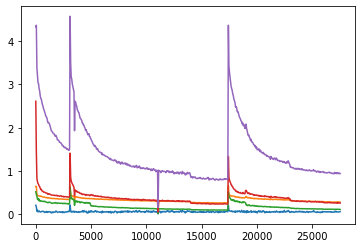

In [0]:
y = np.arange(0,30000,50)
plt.plot(y,adv)
plt.plot(y,edg)
plt.plot(y,pl)
plt.plot(y,rec)
plt.plot(y,ttl)


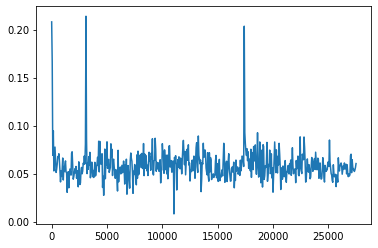

In [0]:
plt.plot(y,adv)

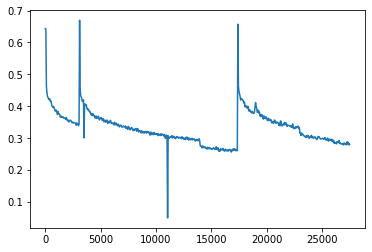

In [0]:
plt.plot(y,edg)

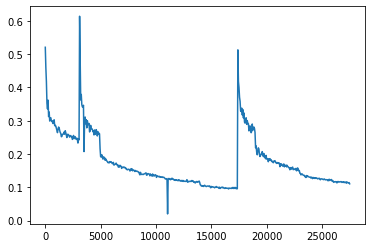

In [0]:
plt.plot(y,pl)

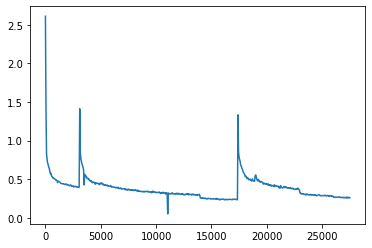

In [0]:
plt.plot(y,rec)

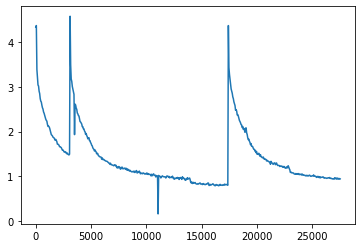

In [0]:
plt.plot(y,ttl)

## The following cells are from [FaceSwap_GAN_v2.2_video_conversion.ipynb](https://github.com/shaoanlu/faceswap-GAN/blob/master/FaceSwap_GAN_v2.2_video_conversion.ipynb)

# Video conversion

In [0]:
from converter.video_converter import VideoConverter

In [0]:
global model, vggface
global train_batchA, train_batchB
del model
del vggface
del train_batchA
del train_batchB
tf.reset_default_graph()
K.clear_session()
model = FaceswapGANModel(**arch_config)
model.load_weights(path=models_dir)

In [0]:
fd = MTCNNFaceDetector(sess=K.get_session(), model_path="./mtcnn_weights/")
vc = VideoConverter()
vc.set_face_detector(fd)
vc.set_gan_model(model)

In [0]:
options = {
    # ===== Fixed =====
    "use_smoothed_bbox": True,
    "use_kalman_filter": True,
    "use_auto_downscaling": False,
    "bbox_moving_avg_coef": 0.65,
    "min_face_area": 35 * 35,
    "IMAGE_SHAPE": model.IMAGE_SHAPE,
    # ===== Tunable =====
    "kf_noise_coef": 1e-3,
    "use_color_correction": "hist_match",
    "detec_threshold": 0.8,
    "roi_coverage": 0.9,
    "enhance": 0.,
    "output_type": 3,
    "direction": "AtoB", # ==================== This line determines the transform direction ====================
}

In [0]:
if options["direction"] == "AtoB":
    input_fn = fn_source_video
    output_fn = "OUTPUT_VIDEO_AtoB.mp4"
elif options["direction"] == "BtoA":
    input_fn = fn_target_video
    output_fn = "OUTPUT_VIDEO_BtoA.mp4"

duration = None # None or a non-negative float tuple: (start_sec, end_sec). Duration of input video to be converted

In [0]:
vc.convert(input_fn=input_fn, output_fn=output_fn, options=options, duration=duration)

# Download result video

In [0]:
from google.colab import files

In [0]:
if options["direction"] == "AtoB":
    files.download("OUTPUT_VIDEO_AtoB.mp4")
elif options["direction"] == "BtoA":
    files.download("OUTPUT_VIDEO_BtoA.mp4")